In [452]:
from imageio import imread
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import pandas as pd

C:\Users\sanfe\AppData\Local\Temp\ipykernel_12300\1043606665.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  terrain1 = imread('SRTM_data_Norway_1.tif')


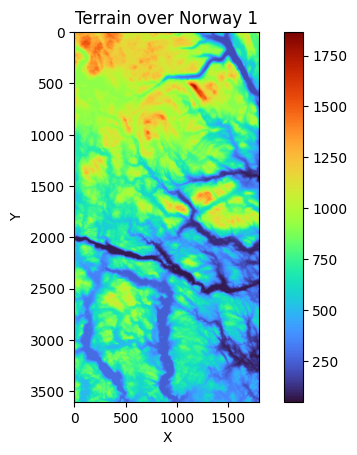

In [453]:
# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')

# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap = "turbo")
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.show()

In [454]:
terrain1.shape

(3601, 1801)

The dataset is a grid of dimension 3601x1801.

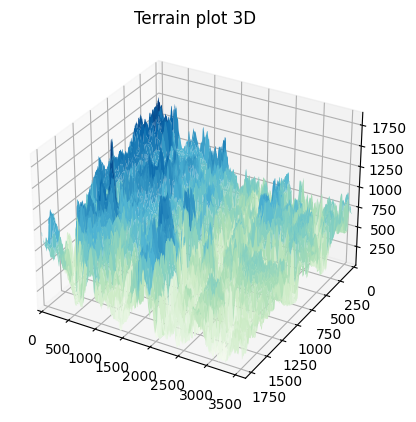

In [455]:
# Represent the entire dataset in a 3D plot, with colors according to the height of the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.meshgrid(range(3601), range(1801))
surf = ax.plot_surface(x.T, y.T, terrain1, cmap = "GnBu")
ax.set_xlim(0, 3601)
ax.set_ylim(1801, 0)
plt.title("Terrain plot 3D")
plt.savefig("Terrain plot 3D.png")
plt.show()

In [458]:
#create design matrix
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

def MSE(y_data, y_model):
	n = np.size(y_model)
	y_data = y_data.reshape(-1,1)
	y_model = y_model.reshape(-1,1)
	return np.sum((y_data - y_model)**2)/n

def rsquare(y, ypredict):
	ypredict = ypredict.reshape(-1,1)
	return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))

# Define a function which applies min-mas scaling
def min_max_scaling(x):
    return (x-min(x))/(max(x)-min(x))

We decided to apply min-max scaling in order to tramsform all of our data in values between 0 and 1. In this way, all the data that we have can be compared without problems of any kind.

In [459]:
# Select at random 1500 points from the entire set of points (there are too many points and otherwise the models will be very slow)
num_points = 1500
points = np.zeros([num_points, 2])
points = np.column_stack((np.random.randint(0, terrain1.shape[0], size = 1500), np.random.randint(0, terrain1.shape[1], size = 1500)))

# The z vector now contains only the values relative to the 1500 randomly selected point
z = np.zeros([num_points, 1])
for i in range(num_points):
    z[i] = terrain1[int(points[i,0])][int(points[i,1])]

# Scale the data
z = min_max_scaling(z)

points = np.column_stack((min_max_scaling(points[:,0]), min_max_scaling(points[:,1])))

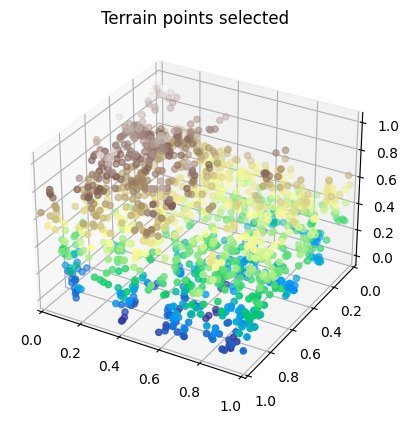

In [460]:
# Represent the selected points into a 3D scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
x, y = np.meshgrid(range(3601), range(1801))
ax.scatter(points[:,0], points[:,1], z, cmap = "terrain", c = z) # Create a scatterplot with colors according to the height of the point
plt.title("Terrain points selected")
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
plt.savefig("Terrain points selected.png")
plt.show()

**OLS**

In [461]:
maxdegree = 20

X = create_X(points[:, 0], points[:, 1], maxdegree)

# Removing the intercept column
X = X[:, 1:]

# Split in train and test data
x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

<Figure size 640x480 with 0 Axes>

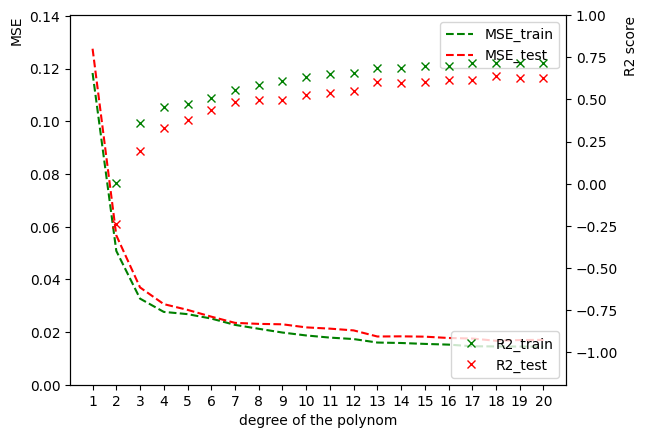

In [462]:
MSE_train = np.zeros(maxdegree)
MSE_test = np.zeros(maxdegree)
rsqr_train = np.zeros(maxdegree)
rsqr_test = np.zeros(maxdegree)

for i in range(1, maxdegree+1):
        c = int((i+2)*(i+1)/2)
        X_tilde = x_train[:,0:c-1]
        beta = np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ z_train
		
        ypredict = X_tilde @ beta
        ypredict_test = x_test[:,0:c-1] @ beta

        MSE_train[i-1] = MSE(z_train, ypredict)
        MSE_test[i-1] = MSE(z_test, ypredict_test)
        rsqr_train[i-1]= rsquare(z_train, ypredict)
        rsqr_test[i-1]= rsquare(z_test, ypredict_test)

# plotting the MSE and R^2 as functions of the polynomial degree
fig = plt.figure()

fig2, ax1 = plt.subplots()
plt.xlabel("degree of the polynom")
xax = np.arange(1, maxdegree + 1)
plt.xticks(xax)
ax2 = ax1.twinx()
ax2.set_ylim(np.min(rsqr_train)*0.9, 1)
ax1.set_ylim(0, np.max(MSE_test)*1.1)
ax1.plot(xax, MSE_train, 'g--', label='MSE_train')
ax1.plot(xax, MSE_test, 'r--', label='MSE_test')
ax2.plot(xax, rsqr_train, 'gx', label='R2_train')
ax2.plot(xax, rsqr_test, 'rx', label='R2_test')
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
ax1.set_ylabel('MSE', loc='top')
ax2.set_ylabel('R2 score', loc='top')
plt.show()

In [463]:
MSE_test_OLS = MSE_test
MSE_test_OLS

array([0.12751626, 0.05667979, 0.03693197, 0.03059088, 0.02840887,
       0.0258348 , 0.02347958, 0.02308991, 0.02293121, 0.02176332,
       0.02128376, 0.02061568, 0.01829993, 0.01836262, 0.01824156,
       0.01773632, 0.01752664, 0.01667868, 0.01695611, 0.01702452])

**Ridge**

In [464]:
# Set the values of lambda
nlambdas = 100
lambdas = np.logspace(-4, 20, nlambdas)

MSE_train = np.zeros((nlambdas, maxdegree))
MSE_test = np.zeros((nlambdas, maxdegree))
rsqr_train = np.zeros((nlambdas, maxdegree))
rsqr_test = np.zeros((nlambdas, maxdegree))

# Split in train and test data
#x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

# Apply ridge for every combination of polynomial degree and lambda
for j in range(nlambdas):
    for i in range(1, maxdegree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = x_train[:,0:c-1]
            beta = np.linalg.pinv(X_tilde.T @ X_tilde + lambdas[j]*np.ones((len(X_tilde.T),len(X_tilde.T)))) @ X_tilde.T @ z_train
            
            ypredict = X_tilde @ beta
            ypredict_test = x_test[:,0:c-1] @ beta

            # Store the values of MSE and R2
            MSE_train[j, i-1] = MSE(z_train, ypredict)
            MSE_test[j, i-1] = MSE(z_test, ypredict_test)
            rsqr_train[j, i-1]= rsquare(z_train, ypredict)
            rsqr_test[j, i-1]= rsquare(z_test, ypredict_test)

In [465]:
MSE_Ridge_df = pd.DataFrame(MSE_test, index = lambdas, columns = range(1, maxdegree+1))
MSE_Ridge_df = MSE_Ridge_df.T

# Create a new column "MSE" containing the minimum value for each row
MSE_Ridge_df[["MSE", "lambda"]] = MSE_Ridge_df.apply(lambda row: pd.Series([row.min(), row.idxmin()]), axis=1)

# Drop the original columns to keep only "min_value" and "min_column"
MSE_Ridge_df.drop(MSE_Ridge_df.columns.difference(["MSE", "lambda"]), axis=1, inplace=True)

MSE_Ridge_df

,MSE,lambda
1,0.127516,1.000000e-04
2,0.056680,1.000000e-04
3,0.036932,1.000000e-04
4,0.030591,1.000000e-04
5,0.028409,1.000000e-04
6,0.025130,2.310130e+08
7,0.023480,1.000000e-04
8,0.022943,9.326033e+04
9,0.022102,3.274549e+03
10,0.021528,2.154435e+01


The above table whows the values of lambda that minimize that minimize the MSE for each polynomial degree, together with the correspondent MSE value. We can show the plots for some values of lambda.

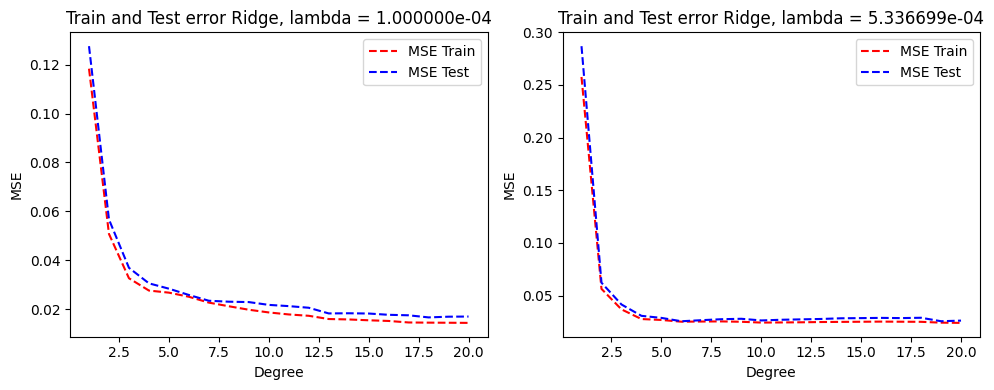

In [466]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot for lambda = 1.000000e-04
axs[0].plot(range(1, maxdegree + 1), MSE_train[0], 'r--', label='MSE Train')
axs[0].plot(range(1, maxdegree + 1), MSE_test[0], 'b--', label='MSE Test')
axs[0].set_xlabel('Degree')
axs[0].set_ylabel('MSE')
axs[0].set_title('Train and Test error Ridge, lambda = 1.000000e-04')
axs[0].legend()

# Plot for lambda = 132194114.84660287
axs[1].plot(range(1, maxdegree + 1), MSE_train[50], 'r--', label='MSE Train')
axs[1].plot(range(1, maxdegree + 1), MSE_test[50], 'b--', label='MSE Test')
axs[1].set_xlabel('Degree')
axs[1].set_ylabel('MSE')
axs[1].set_title('Train and Test error Ridge, lambda = 5.336699e-04')
axs[1].legend()

plt.tight_layout()
plt.savefig("Ridge_lambda_comparison.png")

# Show the figure
plt.show()

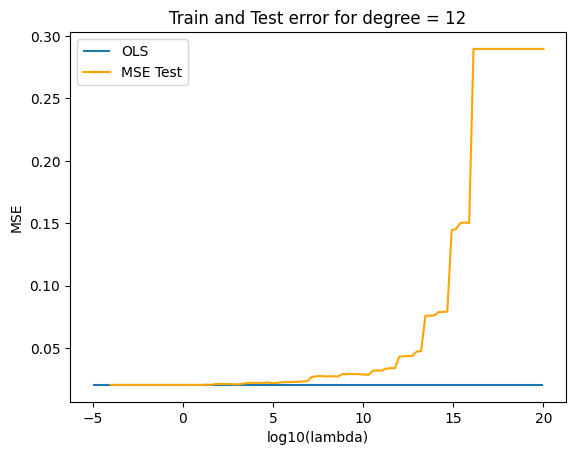

In [467]:
degree = 12

plt.figure()
plt.hlines(MSE_test_OLS[11], -5, 20, label = 'OLS')
plt.plot(np.log10(lambdas), MSE_test[:, 11], 'orange', label = 'Ridge')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Train and Test error for degree = 12')
plt.legend()
plt.savefig("Train and Test error for degree = 12.png")
plt.show()

**Lasso**

In [468]:
# Set the values of lambda
nlambdas = 100
lambdas = np.logspace(-4, 20, nlambdas)

MSE_train_Lasso = np.zeros((nlambdas, maxdegree))
MSE_test_Lasso = np.zeros((nlambdas, maxdegree))
rsqr_train_Lasso = np.zeros((nlambdas, maxdegree))
rsqr_test_Lasso = np.zeros((nlambdas, maxdegree))

# Split in train and test data
#x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

# Apply ridge for every combination of polynomial degree and lambda
for j in range(nlambdas):
    for i in range(1, maxdegree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = x_train[:,0:c-1]
            RegLasso = linear_model.Lasso(lambdas[i])
            RegLasso.fit(X_tilde, z_train)

            ypredict_Lasso = RegLasso.predict(X_tilde)
            ypredict_test_Lasso = RegLasso.predict(x_test[:,0:c-1])

            # Store the values of MSE and R2
            MSE_train_Lasso[j, i-1] = MSE(z_train, ypredict_Lasso)
            MSE_test_Lasso[j, i-1] = MSE(z_test, ypredict_test_Lasso)
            rsqr_train_Lasso[j, i-1] = rsquare(z_train, ypredict_Lasso)
            rsqr_test_Lasso[j, i-1] = rsquare(z_test, ypredict_test_Lasso)

In [469]:
MSE_test_Lasso

array([[0.02545627, 0.02371571, 0.02324768, ..., 0.0472258 , 0.0472258 ,
        0.0472258 ],
       [0.02545627, 0.02371571, 0.02324768, ..., 0.0472258 , 0.0472258 ,
        0.0472258 ],
       [0.02545627, 0.02371571, 0.02324768, ..., 0.0472258 , 0.0472258 ,
        0.0472258 ],
       ...,
       [0.02545627, 0.02371571, 0.02324768, ..., 0.0472258 , 0.0472258 ,
        0.0472258 ],
       [0.02545627, 0.02371571, 0.02324768, ..., 0.0472258 , 0.0472258 ,
        0.0472258 ],
       [0.02545627, 0.02371571, 0.02324768, ..., 0.0472258 , 0.0472258 ,
        0.0472258 ]])

In [470]:
MSE_Lasso_df = pd.DataFrame(MSE_test_Lasso, index = lambdas, columns = range(1, maxdegree + 1))
MSE_Lasso_df = MSE_Lasso_df.T

# Create a new column "MSE" containing the minimum value for each row
MSE_Lasso_df[["MSE", "lambda"]] = MSE_Lasso_df.apply(lambda row: pd.Series([row.min(), row.idxmin()]), axis = 1)

# Drop the original columns to keep only "min_value" and "min_column"
MSE_Lasso_df.drop(MSE_Lasso_df.columns.difference(["MSE", "lambda"]), axis = 1, inplace = True)

MSE_Lasso_df

,MSE,lambda
1,0.025456,0.0001
2,0.023716,0.0001
3,0.023248,0.0001
4,0.023238,0.0001
5,0.023656,0.0001
6,0.024581,0.0001
7,0.025002,0.0001
8,0.026065,0.0001
9,0.029603,0.0001
10,0.039850,0.0001


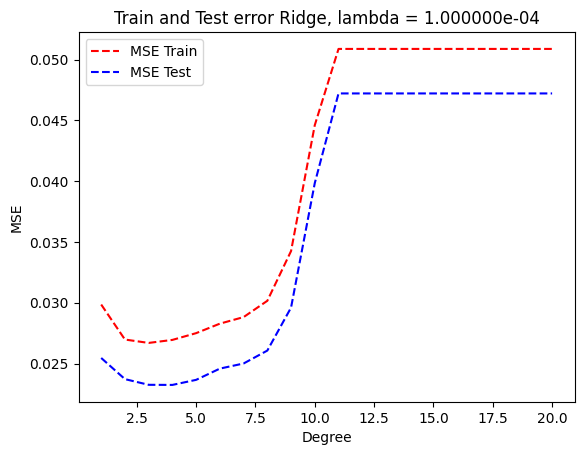

In [471]:
# Plot for lambda = 1.000000e-04
plt.figure()
plt.plot(range(1, maxdegree+1), MSE_train_Lasso[0], 'r--', label = 'MSE Train')
plt.plot(range(1, maxdegree+1), MSE_test_Lasso[0], 'b--', label = 'MSE Test')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Train and Test error Ridge, lambda = 1.000000e-04')
plt.legend()
plt.savefig("Ridge lambda 1.png")
plt.show()

Finally add the comparison between the three methods.